In [4]:
# import tarfile
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage.io
from skimage.transform import resize
import torch
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
import PIL
import math
from tqdm import tqdm
from torch import nn
from torch.nn import functional as F
from torch.utils.data.sampler import SubsetRandomSampler
from random import randint
from skimage.morphology import binary_erosion
from skimage.morphology import diameter_opening
import cmath
from joblib import Parallel, delayed
from tqdm.notebook import tqdm_notebook
import numpy as np

# Loading the clean operators from operators folder
operators_names = ['divide', 'equal', 'minus', 'multiply', 'plus']
ic_operators = skimage.io.imread_collection([os.path.join('operators', operator, operator + '.png') for operator in operators_names])
image_shape = ic_operators[0].shape
ic_same_shape = [resize(image, image_shape) for image in ic_operators]
operators = skimage.io.concatenate_images(ic_same_shape)

# Loading the video images from video_dataset folder
ic_video = skimage.io.imread_collection([os.path.join('video_dataset', f'objects{i}.png') for i in range(10)])
video_symbols = skimage.io.concatenate_images(ic_video)

# Loading the images from MNIST dataset
mnist_train_set = datasets.MNIST('', train = True)
mnist_test_set = datasets.MNIST('', train = False)
train_input_MNIST = mnist_train_set.data.float().numpy()
train_target_MNIST = mnist_train_set.targets.numpy()
test_input_MNIST = mnist_test_set.data.float().numpy()
test_target_MNIST = mnist_test_set.targets.numpy()

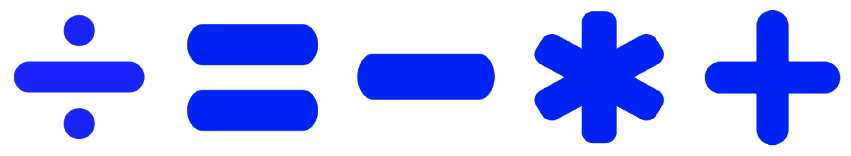

In [5]:
f, ax = plt.subplots(1, len(operators), figsize=(15, 7))
for a, img in zip(ax, operators):
    a.imshow(img, cmap='gray')
    a.axis('off')

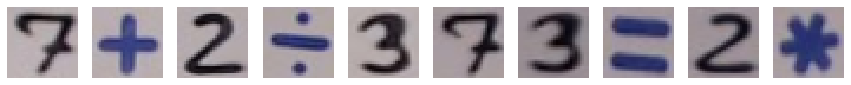

In [6]:
f, ax = plt.subplots(1, len(video_symbols), figsize=(15, 7))
for a, img in zip(ax, video_symbols):
    a.imshow(img, cmap='gray')
    a.axis('off')

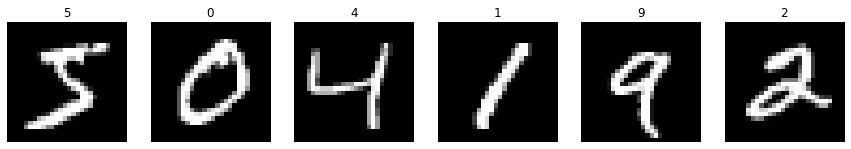

In [7]:
num = 6

f, ax = plt.subplots(1, num, figsize=(15, 7))
for a, img, target in zip(ax, train_input_MNIST[:num], train_target_MNIST[:num]):
    a.imshow(img, cmap='gray')
    a.axis('off')
    a.set_title(target)

In [5]:
def get_contour_from_binary(binary_image):
    # We make an opening big enough to remove stains (like in 1_8.png)
    opening = diameter_opening(binary_image, 4.5)
    
    # Then we create an erosed image
    erosion = binary_erosion(opening)
    
    # And finally remove that erosed image from the original one (XOR operation), leaving only the contour.
    return binary_erosion(opening) ^ opening

def get_outside_contours(image):
    # Getting outside contour starting with top middle point and going in
    # counter-clockwise order.
    
    neighbors = [(0,-1),(1,-1),(1,0),(1,1),(0,1),(-1,1),(-1,0),(-1,-1)]
    arrow = 0
    contour = []
    
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if image[i,j]: 

                last_pix = (i,j)
                arrow = 0
                contour.append((i,j))
                break
        if len(contour): break

    if len(contour):
        while contour[0] != contour[-1] or len(contour)==1:
            for i in range(len(neighbors)):
                direction = neighbors[ (arrow+i)%len(neighbors) ]
                new_pix = (contour[-1][0]+direction[0],contour[-1][1]+direction[1])
                
                if (new_pix[0] > 27) or (new_pix[0] < 0):
                    continue
                if (new_pix[1] > 27) or (new_pix[1] < 0):
                    continue
                    
                if image[new_pix[0],new_pix[1]]:
                    contour.append((new_pix))
                    arrow = (arrow+i - 2)%len(neighbors)
                    break
    return contour

def get_scaled_fourier_descriptors(contour, scale_by_i=1):
    coeffs = list(range(1, len(contour)))
    L = len(coeffs)
    descriptors = np.zeros((L,), dtype=complex)
    
    for l in range(L):
        for k in range(len(contour)):
            descriptors[l] += complex(contour[k][0], contour[k][1])*cmath.exp(-1j*2.0*cmath.pi*k*coeffs[l]/len(contour))
                
        descriptors[l] = abs(descriptors[l])
    
    descriptors_real = np.real(descriptors)
    
    scaled_descriptors = descriptors_real[np.arange(len(descriptors_real))!=scale_by_i] / descriptors_real[scale_by_i]
    
    return scaled_descriptors

def get_moment(binary_image, i, j):
    """
        Get M_i_j - i-th and j-th moment of the binary image.
        
        Parameters
        ----------
        binary_image : 2D array with binary or boolean values
            The binary image
        i : int
            The i index of the moment
        j : int
            The j index of the moment
            
        Returns
        -------
        int
            The M_i_j moment.
    """
    
    M_i_j = 0
    
    for k in range(binary_image.shape[0]):
        for l in range(binary_image.shape[1]):
            M_i_j += k**i * l**j * binary_image[k, l]
            
    return M_i_j
            
def get_centered_moment(binary_image, i, j, with_scaled=True):
    """
        Get centered M_i_j of the binary image.
        
        Parameters
        ----------
        binary_image : 2D array with binary or boolean values
            The binary image
        i : int
            The i index of the moment
        j : int
            The j index of the moment
        with_scaled : boolean
            True if scale the centered moment, False if not
            
        Returns
        -------
        float or (float, float)
            If with_scaled is True returns unscaled and scaled
            centered moment, if with_scaled is False returns
            only centered moment.
    """
    
    # Getting "the centers of gravity"
    k_mean = get_moment(binary_image, 1, 0)/get_moment(binary_image, 0, 0)
    l_mean = get_moment(binary_image, 0, 1)/get_moment(binary_image, 0, 0)
    
    # Getting the scaling factor
    mu_0_0 = get_moment(binary_image, 0, 0)
    
    mu_i_j = 0
    for k in range(binary_image.shape[0]):
        for l in range(binary_image.shape[1]):
            mu_i_j += (k - k_mean)**i * (l - l_mean)**j * binary_image[k, l]
    
    # Applying scaling
    eta_i_j = mu_i_j/mu_0_0**((i+j)/2 + 1)
    
    if with_scaled:
        return mu_i_j, eta_i_j
    else:
        return mu_i_j
    
def get_first_4_Hu_moments(binary_image, with_scaled=True):
    """
        Get first 4 Hu moments, which are invariant to rotation.
        
        Parameters
        ----------
        binary_image : 2D array with binary or boolean values
            The binary image
        
        with_scaled : boolean
            True if scale the HU moment, False if not
            
        Returns
        -------
        list of 4 elements
            First 4 HU moments.
    """
    if with_scaled:
        _, val_0_2 = get_centered_moment(binary_image, 0, 2)
        _, val_2_0 = get_centered_moment(binary_image, 2, 0)
        _, val_1_1 = get_centered_moment(binary_image, 1, 1)
        _, val_1_2 = get_centered_moment(binary_image, 1, 2)
        _, val_2_1 = get_centered_moment(binary_image, 2, 1)
        _, val_3_0 = get_centered_moment(binary_image, 3, 0)
        _, val_0_3 = get_centered_moment(binary_image, 0, 3)
    else:
        val_0_2 = get_centered_moment(binary_image, 0, 2, with_scaled=False)
        val_2_0 = get_centered_moment(binary_image, 2, 0, with_scaled=False)
        val_1_1 = get_centered_moment(binary_image, 1, 1, with_scaled=False)
        val_1_2 = get_centered_moment(binary_image, 1, 2, with_scaled=False)
        val_2_1 = get_centered_moment(binary_image, 2, 1, with_scaled=False)
        val_3_0 = get_centered_moment(binary_image, 3, 0, with_scaled=False)
        val_0_3 = get_centered_moment(binary_image, 0, 3, with_scaled=False)
    
    I_1 = val_2_0 + val_0_2
    I_2 = (val_2_0 - val_0_2)**2 + 4*val_1_1**2
    I_3 = (val_3_0 - 3*val_1_2)**2 + (3*val_2_1 - val_0_3)**2
    I_4 = (val_3_0 + val_1_2)**2 + (val_2_1 + val_0_3)**2
    
    return [I_1, I_2, I_3, I_4]

def inverse_black_white(image):
    return 255-image

def binarize_image(image):
    return image < 128

def get_fourier_features(image):
    opening = diameter_opening(image > 128, 4.5)
    contour = binary_erosion(opening) ^ opening
    outside_contour = get_outside_contours(contour)
    if outside_contour:
        fourier = get_scaled_fourier_descriptors(outside_contour)
    else:
        fourier = []
    return fourier

def get_fourier_feature_set(input_data, target_data):
    outside_contours = [get_outside_contours(image > 128) for image in input_data]
    fourier_descriptors = [get_scaled_fourier_descriptors(outside_contour) for outside_contour in outside_contours]
    min_descriptors = 50
    len_data = len(target_data)
    i = 0
    while i != len_data:
        if len(fourier_descriptors[i]) >= min_descriptors:
            fourier_descriptors[i] = fourier_descriptors[i][:min_descriptors]
            i += 1
        else:
            target_data = target_data[np.arange(len_data) != i]
            fourier_descriptors.pop(i)
            len_data -= 1
    return np.array(fourier_descriptors), target_data

In [6]:
%%time

train_fourier =  Parallel(n_jobs=-1)(delayed(get_fourier_features)(image) for image in tqdm_notebook(train_input_MNIST))


CPU times: user 1min 26s, sys: 3.98 s, total: 1min 30s
Wall time: 6min 58s


In [7]:
%%time

test_fourier =  Parallel(n_jobs=-1)(delayed(get_fourier_features)(image) for image in tqdm_notebook(test_input_MNIST))


CPU times: user 15.3 s, sys: 690 ms, total: 16 s
Wall time: 1min 10s


In [8]:
train_input_fourier = []
train_target_fourier = train_target_MNIST
min_descriptors = 50
len_data = 60000
i = 0
while i != len_data:
        if len(train_fourier[i]) >= min_descriptors:
            train_fourier[i] = train_fourier[i][:min_descriptors]
            i += 1
        else:
            train_target_fourier = train_target_fourier[np.arange(len_data) != i]
            train_fourier.pop(i)
            len_data -= 1

In [9]:
test_input_fourier = []
test_target_fourier = test_target_MNIST
min_descriptors = 50
len_data = 10000
i = 0
while i != len_data:
        if len(test_fourier[i]) >= min_descriptors:
            test_fourier[i] = test_fourier[i][:min_descriptors]
            i += 1
        else:
            test_target_fourier = test_target_fourier[np.arange(len_data) != i]
            test_fourier.pop(i)
            len_data -= 1

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

clf = RandomForestClassifier(n_estimators=10, min_samples_split=2, random_state=42)
clf.fit(train_fourier, train_target_fourier)
y_train_pred = clf.predict(train_fourier)
y_test_pred = clf.predict(test_fourier)
print(f'Accuracy score for train: {accuracy_score(train_target_fourier, y_train_pred)}')
print(f'Accuracy score for test:  {accuracy_score(test_target_fourier, y_test_pred)}')

Accuracy score for train: 0.9930447515329002
Accuracy score for test:  0.6281331324476099


In [14]:
import torch
from torch import nn
from torch.nn import functional as F

# Creating a Net class object, which consists of 2 perceptron layers
class MLP_Net(nn.Module):
    
    # The object initialization
    def __init__(self, nb_hidden = 100):        
        super(MLP_Net, self).__init__()
        self.fc1 = nn.Linear(50, nb_hidden)  # the input linear layer, which get raw pixel values
        self.fc2 = nn.Linear(nb_hidden, 10)  # the output linear layer, which outputs probs for all digits
    
    # Creating the forward pass
    def forward(self, x):
        
        # First perceptron layer
        x = F.relu(self.fc1(x))
        
        # Second perceptron layer
        x = self.fc2(x)
        
        return x

In [15]:
def train_model(model, train_inputs, train_targets, mini_batch_size=100, remember_losses=True, lr=1e-3, nb_epochs=20):
    
    """
        Train the PyTorch model on the training set.
        
        Parameters
        ----------
        model : PyTorch NN object
            PyTorch neural network model      
        train_inputs : torch.Tensor object
            The input train feature set
        train_targets : torch.Tensor object
            The input train label set
        mini_batch_size : int
            The size of the batch processing size
        remember_losses : boolean
            True if remember losses for model evaluation, False if not
        lr : float
            Learning rate for the model training
        nb_epochs : int
            The number of epochs used to train the model
            
        Returns
        -------
        
        NN object or (NN object, list)
            If remember_losses is True then the function returns both
            the trained model and the list of losses for each epoch. 
            If remember_losses is False then the function return only
            the trained model.
    """
    
    # Defining the learning rate and number of epochs
    losses = []

    # Defining the optimizer for GD
    optimizer = torch.optim.Adam(model.parameters(), lr = lr) 
    
    # Defining the criterion to calculate loss
    criterion = nn.CrossEntropyLoss()
    
    # Learning loop
    for e in range(nb_epochs):
        # Train the input dataset by dividing it into mini_batch_size small datasets
        for train_input, train_target in zip(train_inputs.split(mini_batch_size), train_targets.split(mini_batch_size)):
            output = model(train_input)
            loss = criterion(output, train_target) 
            optimizer.zero_grad() 
            loss.backward()
            optimizer.step()
        losses.append(loss)
        print('%dth epoch is finished and the loss is %f' % (e+1, loss))
           
    
    return model, losses
        
def compute_nb_errors(model, data_inputs, targets, mini_batch_size=100):
    
    """
        Compute the number of errors the model infers on the data set.
        
        Parameters
        ----------
        model : PyTorch NN object
            PyTorch neural network model      
        tensor_inputs : torch.Tensor object
            The input feature set
        targets : torch.Tensor object
            The input label set
        mini_batch_size : int
            The size of the batch processing size
            
        Returns
        -------
        int
            The number of errors the model infers
    """
    
    nb_errors = 0
    
    # Processing the data set by mini batches
    for data_input, target in zip(data_inputs.split(mini_batch_size), targets.split(mini_batch_size)):
        output = model(data_input)
        _, predicted_classes = output.max(1)
        nb_errors += (target != predicted_classes).sum().item()
                
    return nb_errors

In [19]:
# Create a MLP object
MLP = MLP_Net()

# Train the model
nb_epochs = 30
MLP, losses = train_model(MLP, torch.Tensor(train_fourier), torch.Tensor(train_target_fourier).long(), nb_epochs=nb_epochs)

1th epoch is finished and the loss is 1.468652
2th epoch is finished and the loss is 1.301339
3th epoch is finished and the loss is 1.194859
4th epoch is finished and the loss is 1.133856
5th epoch is finished and the loss is 1.092987
6th epoch is finished and the loss is 1.040658
7th epoch is finished and the loss is 1.002783
8th epoch is finished and the loss is 0.973376
9th epoch is finished and the loss is 0.948611
10th epoch is finished and the loss is 0.915583
11th epoch is finished and the loss is 0.890555
12th epoch is finished and the loss is 0.857246
13th epoch is finished and the loss is 0.833205
14th epoch is finished and the loss is 0.806976
15th epoch is finished and the loss is 0.789026
16th epoch is finished and the loss is 0.769462
17th epoch is finished and the loss is 0.750095
18th epoch is finished and the loss is 0.729512
19th epoch is finished and the loss is 0.716064
20th epoch is finished and the loss is 0.698617
21th epoch is finished and the loss is 0.681904
2

In [21]:
# Calculate the number of errors on the training set and on the test set.
train_fourier_tensor = torch.Tensor(train_fourier)
test_fourier_tensor = torch.Tensor(test_fourier)
train_target_fourier_tensor = torch.Tensor(train_target_fourier).long()
test_target_fourier_tensor = torch.Tensor(test_target_fourier).long()

nb_errors_train = compute_nb_errors(MLP, train_fourier_tensor, train_target_fourier_tensor)
nb_errors_test = compute_nb_errors(MLP, test_fourier_tensor, test_target_fourier_tensor)

accuracy_train = (train_fourier_tensor.size(0) - nb_errors_train) / train_fourier_tensor.size(0)
accuracy_test = (test_fourier_tensor.size(0) - nb_errors_test) / test_fourier_tensor.size(0)
print(f"Accuracy train: {accuracy_train:0.4f}, test: {accuracy_test:0.4f}")

Accuracy train: 0.7213, test: 0.7189


In [2]:
white = 255
black = 0

def inverse_color(img):
    return PIL.Image.eval(img, lambda val: 255 - val)

def fix_background_color_bug(img):
    colors = sorted(img.getcolors(), key=lambda pair: pair[0], reverse=True)
    replace_color = colors[0][1]
    remove_color = colors[2][1] if colors[2][1] > colors[1][1] else colors[1][1]

    data = np.array(img)
    data[data == remove_color] = replace_color
    return PIL.Image.fromarray(data)

def to_binary(img):
    return PIL.Image.eval(img, lambda val: 255 if val < (256/2) else 0)

def get_contour_from_binary(binary_image):
    # We make an opening big enough to remove stains (like in 1_8.png)
    opening = diameter_opening(binary_image, 4.5)
    
    # Then we create an erosed image
    erosion = binary_erosion(opening)
    
    # And finally remove that erosed image from the original one (XOR operation), leaving only the contour.
    return binary_erosion(opening) ^ opening

In [3]:
operators_transforms_binary = (
    transforms.Compose([transforms.Grayscale(num_output_channels=1),
                        transforms.RandomRotation(360, fill=(0,)), 
                        transforms.Resize((30, 30)),
                        transforms.Lambda(inverse_color),
                        transforms.Lambda(to_binary),
                        transforms.ToTensor()])
)

digits_transforms_binary = (
    transforms.Compose([transforms.RandomRotation(360, fill=(0,)), 
                        transforms.Resize((30, 30)),
                        transforms.Lambda(to_binary),
                        transforms.ToTensor()])
)

operators_transforms_grayscale = (
    transforms.Compose([transforms.Grayscale(num_output_channels=1),
                        transforms.Lambda(inverse_color),
                        transforms.RandomRotation(360, fill=(0,)),
                        transforms.Resize((30, 30)),
                        transforms.ColorJitter(brightness=(0.8, 1), contrast=(0.45, 1)),
                        transforms.ToTensor()])
)

digits_transforms_grayscale = (
    transforms.Compose([transforms.RandomRotation(360, fill=(0,)),
                        transforms.Resize((30, 30)),
                        transforms.ColorJitter(brightness=(0.8, 1), contrast=(0.45, 1)),
                        transforms.ToTensor()])
)

In [129]:
class FusionDataset(datasets.VisionDataset):

    def __init__(self, operators_dataset, minst_dataset):
        self.operators_dataset = operators_dataset
        self.minst_dataset = minst_dataset

    def __getitem__(self, index):
        if index < len(self.operators_dataset):
            tensor, class_index = self.operators_dataset[index]   
            tensor = transforms.Normalize(operators_mean, operators_std)(tensor)
            return tensor, class_index + 10
        else:
            tensor, class_index = self.minst_dataset[index - len(self.operators_dataset)]
            tensor = transforms.Normalize(minst_mean, minst_std)(tensor)
            return tensor, class_index

    def __len__(self):
        return len(self.minst_dataset) + len(self.operators_dataset)
    
def get_loaders(dataset, batch_size=100, validation_split=0.2, shuffle_dataset=True):
    # Creating data indices for training and validation splits:
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    split = int(np.floor(validation_split * dataset_size))
    if shuffle_dataset:
        np.random.seed(randint(0, 100))
        np.random.shuffle(indices)
    train_indices, val_indices = indices[split:], indices[:split]

    # Creating PT data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)

    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                               sampler=train_sampler)
    validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                    sampler=valid_sampler)
    
    return train_loader, validation_loader

In [131]:
mnist_dataset = datasets.MNIST("", transform=operators_transforms_binary, download=True)
operators_dataset = datasets.ImageFolder(root='operators', transform=digits_transforms_binary)

dataset = FusionDataset(operators_dataset, mnist_dataset)

In [134]:
image, target = dataset[5]
plt.imshow(image[0, :, :])

TypeError: function takes at least 3 arguments (1 given)

In [139]:
mean, std = get_stats(dataset)
mean, std

(tensor([-0.0810]), tensor([1.0834]))

In [230]:
test_loader

In [140]:
train_loader, test_loader = get_loaders(dataset)

8


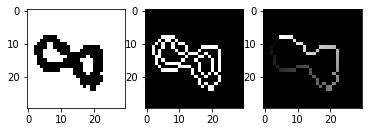

In [225]:
def get_outside_contours(image):
    # Getting outside contour starting with top middle point and going in
    # counter-clockwise order.
    
    neighbors = [(0,-1),(1,-1),(1,0),(1,1),(0,1),(-1,1),(-1,0),(-1,-1)]
    arrow = 0
    contour = []
    
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if image[i,j]: 

                last_pix = (i,j)
                arrow = 0
                contour.append((i,j))
                break
        if len(contour): break

    if len(contour):
        while contour[0] != contour[-1] or len(contour)==1 :
            for i in range(len(neighbors)):
                direction = neighbors[ (arrow+i)%len(neighbors) ]
                new_pix = (contour[-1][0]+direction[0],contour[-1][1]+direction[1])

                if image[new_pix[0],new_pix[1]]:
                    contour.append((new_pix))
                    arrow = (arrow+i - 2)%len(neighbors)
                    break
    return contour

for train_input, train_target in train_loader:
    f, ax = plt.subplots(1, 3)
    image = train_input[0, 0, :, :].numpy()
    ax[0].imshow(image, cmap='gray')
    binary_image = get_contour(image < 0)
    ax[1].imshow(binary_image, cmap='gray')
    out_contour = get_outside_contours(binary_image)
    ordered_contour = np.zeros_like(image)
    for i in range(len(out_contour)):
        ordered_contour[out_contour[i]]= i
    ax[2].imshow(ordered_contour, cmap='gray')
    print(train_target[0].item())
    descriptors = get_scaled_fourier_descriptors(out_contour, 1)
    break

In [223]:
def get_scaled_fourier_descriptors(contour, scale_by_i=1):
    coeffs = list(range(1, len(contour)))
    L = len(coeffs)
    descriptors = np.zeros((L,), dtype=complex)
    
    for l in range(L):
        for k in range(len(contour)):
            descriptors[l] += complex(contour[k][0], contour[k][1])*cmath.exp(-1j*2.0*cmath.pi*k*coeffs[l]/len(contour))
                
        descriptors[l] = abs(descriptors[l])
    
    descriptors_real = np.real(descriptors)
    
    scaled_descriptors = descriptors_real[np.arange(len(descriptors_real))!=scale_by_i] / descriptors_real[scale_by_i]
    
    return scaled_descriptors

In [226]:
def get_moment(binary_image, i, j):
    """
        Get M_i_j - i-th and j-th moment of the binary image.
        
        Parameters
        ----------
        binary_image : 2D array with binary or boolean values
            The binary image
        i : int
            The i index of the moment
        j : int
            The j index of the moment
            
        Returns
        -------
        int
            The M_i_j moment.
    """
    
    M_i_j = 0
    
    for k in range(binary_image.shape[0]):
        for l in range(binary_image.shape[1]):
            M_i_j += k**i * l**j * binary_image[k, l]
            
    return M_i_j
            
def get_centered_moment(binary_image, i, j, with_scaled=True):
    """
        Get centered M_i_j of the binary image.
        
        Parameters
        ----------
        binary_image : 2D array with binary or boolean values
            The binary image
        i : int
            The i index of the moment
        j : int
            The j index of the moment
        with_scaled : boolean
            True if scale the centered moment, False if not
            
        Returns
        -------
        float or (float, float)
            If with_scaled is True returns unscaled and scaled
            centered moment, if with_scaled is False returns
            only centered moment.
    """
    
    # Getting "the centers of gravity"
    k_mean = get_moment(binary_image, 1, 0)/get_moment(binary_image, 0, 0)
    l_mean = get_moment(binary_image, 0, 1)/get_moment(binary_image, 0, 0)
    
    # Getting the scaling factor
    mu_0_0 = get_moment(binary_image, 0, 0)
    
    mu_i_j = 0
    for k in range(binary_image.shape[0]):
        for l in range(binary_image.shape[1]):
            mu_i_j += (k - k_mean)**i * (l - l_mean)**j * binary_image[k, l]
    
    # Applying scaling
    eta_i_j = mu_i_j/mu_0_0**((i+j)/2 + 1)
    
    if with_scaled:
        return mu_i_j, eta_i_j
    else:
        return mu_i_j
    
def get_first_4_Hu_moments(binary_image, with_scaled=True):
    """
        Get first 4 Hu moments, which are invariant to rotation.
        
        Parameters
        ----------
        binary_image : 2D array with binary or boolean values
            The binary image
        
        with_scaled : boolean
            True if scale the HU moment, False if not
            
        Returns
        -------
        list of 4 elements
            First 4 HU moments.
    """
    if with_scaled:
        _, val_0_2 = get_centered_moment(binary_image, 0, 2)
        _, val_2_0 = get_centered_moment(binary_image, 2, 0)
        _, val_1_1 = get_centered_moment(binary_image, 1, 1)
        _, val_1_2 = get_centered_moment(binary_image, 1, 2)
        _, val_2_1 = get_centered_moment(binary_image, 2, 1)
        _, val_3_0 = get_centered_moment(binary_image, 3, 0)
        _, val_0_3 = get_centered_moment(binary_image, 0, 3)
    else:
        val_0_2 = get_centered_moment(binary_image, 0, 2, with_scaled=False)
        val_2_0 = get_centered_moment(binary_image, 2, 0, with_scaled=False)
        val_1_1 = get_centered_moment(binary_image, 1, 1, with_scaled=False)
        val_1_2 = get_centered_moment(binary_image, 1, 2, with_scaled=False)
        val_2_1 = get_centered_moment(binary_image, 2, 1, with_scaled=False)
        val_3_0 = get_centered_moment(binary_image, 3, 0, with_scaled=False)
        val_0_3 = get_centered_moment(binary_image, 0, 3, with_scaled=False)
    
    I_1 = val_2_0 + val_0_2
    I_2 = (val_2_0 - val_0_2)**2 + 4*val_1_1**2
    I_3 = (val_3_0 - 3*val_1_2)**2 + (3*val_2_1 - val_0_3)**2
    I_4 = (val_3_0 + val_1_2)**2 + (val_2_1 + val_0_3)**2
    
    return [I_1, I_2, I_3, I_4]